<a href="https://colab.research.google.com/github/Alireza-Khodapanah/Scratch-Built-Neural-Networks/blob/main/Scratch-Built-Neural-Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [ ]:
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [ ]:
class NeuralNetwork:
    def __init__(self, samples, labels, size_hidden=30, eta=0.1, my=0.9, epochs=10, optimizer="sgd", verbose=False):
        self.samples = samples
        self.labels = labels
        self.size_hidden = size_hidden
        self.eta = eta
        self.my = my
        self.epochs = epochs
        self.optimizer = optimizer
        self.verbose = verbose
        self._initialize_weights()

    def _initialize_weights(self):
        self.w01 = np.random.random((self.samples.shape[1], self.size_hidden))
        self.w12 = np.random.random((self.size_hidden, self.labels.shape[1]))
        self.v01 = np.zeros_like(self.w01)
        self.v12 = np.zeros_like(self.w12)
        self.g01 = np.zeros_like(self.w01)
        self.g12 = np.zeros_like(self.w12)
        self.b1 = np.zeros((1, self.size_hidden))
        self.b2 = np.zeros((1, self.labels.shape[1]))

    def relu(self, x, deriv=False):
        return np.where(x > 0, 1, 0) if deriv else np.maximum(0, x)

    def softmax(self, x, deriv=False):
        if deriv:
            return np.multiply(x, 1 - x)
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def fit(self):
        accuracy = []
        no_epochs = []
        sample_no = 0

        if self.optimizer == "adagrad":
            gti_01 = np.zeros_like(self.w01)
            gti_12 = np.zeros_like(self.w12)

        for epoch in range(self.epochs):
            l1_delta_batch = np.zeros_like(self.w01)
            l2_delta_batch = np.zeros_like(self.w12)
            for i in range(len(self.samples)):
                sample_no += 1
                l0 = self.samples[i:i + 1]
                y = self.labels[i:i + 1]

                l1 = self.relu(np.dot(l0, self.w01) + self.b1)
                l2 = self.softmax(np.dot(l1, self.w12) + self.b2)

                l2_error = 0.5 * (y - l2) ** 2
                l2_error_total = str(np.mean(np.abs(l2_error)))

                if l2_error_total == '1.0':
                    if self.verbose:
                        print("Overflow")
                    return

                l2_delta = (l2 - y) * self.softmax(l2, deriv=True)
                l2_delta_batch += np.dot(l1.T, l2_delta)

                l1_delta = np.dot(l2_delta, self.w12.T) * self.relu(l1, deriv=True)
                l1_delta_batch += np.dot(l0.T, l1_delta)

            if self.optimizer == "adagrad":
                self._apply_adagrad(l1_delta_batch, l2_delta_batch)

            elif self.optimizer == "sgd":
                self.w01 -= self.eta * l1_delta_batch / len(self.samples)
                self.w12 -= self.eta * l2_delta_batch / len(self.samples)

            elif self.optimizer == "momentum":
                self._apply_momentum(l1_delta_batch, l2_delta_batch)

            if self.verbose and epoch % 1 == 0:
                self._print_verbose(epoch+1, l2_error_total)

            accuracy.append(self._compute_accuracy())
            no_epochs.append(sample_no)

        if self.verbose:
            return no_epochs, accuracy

    def _apply_adagrad(self, l1_delta_batch, l2_delta_batch):
        grad_12 = self.eta * l2_delta_batch
        self.g12 += grad_12 ** 2
        adjusted_grad_12 = grad_12 / np.sqrt(1e-7 + self.g12)
        self.w12 -= adjusted_grad_12

        grad_01 = self.eta * l1_delta_batch
        self.g01 += grad_01 ** 2
        adjusted_grad_01 = grad_01 / np.sqrt(1e-7 + self.g01)
        self.w01 -= adjusted_grad_01

    def _apply_momentum(self, l1_delta_batch, l2_delta_batch):
        self.v01 = self.my * self.v01 + self.eta * l1_delta_batch / len(self.samples)
        self.w01 -= self.v01
        self.v12 = self.my * self.v12 + self.eta * l2_delta_batch / len(self.samples)
        self.w12 -= self.v12

    def _print_verbose(self, epoch, l2_error_total):
        y_pred, y_true = self.predict(X_test, y_test)
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Epoch: {epoch} - Error: {l2_error_total} - Accuracy: {acc} - Precision: {precision} - Recall: {recall} - F1-Score: {f1}")
        y_pred_train, y_true_train = self.predict(X_train, y_train)
        print(f"Epoch: {epoch} - Training Accuracy: {accuracy_score(y_true_train, y_pred_train)}")
        print("-"*25)

    def _compute_accuracy(self):
        y_pred, y_true = self.predict(X_test, y_test)
        return accuracy_score(y_true, y_pred)

    def predict(self, test_samples, test_labels):
        l1 = self.relu(np.dot(test_samples, self.w01) + self.b1)
        l2 = self.softmax(np.dot(l1, self.w12) + self.b2)
        y_pred = np.argmax(l2, axis=1)
        return y_pred, np.argmax(test_labels, axis=1)


###Load and Prepare Dataset

In [ ]:
dataset_path = "/content/WineQT.csv"
dataset = pd.read_csv(dataset_path)
X = dataset.drop(columns=['quality']).values
y = dataset['quality'].values.reshape(-1, 1)

# One-hot encode labels
enc = OneHotEncoder()
labels = enc.fit_transform(y).toarray()

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


###Train Neural Network and Plot Learning Curve

Epoch: 1 - Error: 0.03700407236218124 - Accuracy: 0.35807860262008734 - Precision: 0.16606543889627237 - Recall: 0.35807860262008734 - F1-Score: 0.2269012927493623
Epoch: 1 - Training Accuracy: 0.3588621444201313
-------------------------
Epoch: 2 - Error: 0.16666621197504924 - Accuracy: 0.27074235807860264 - Precision: 0.17099517352332796 - Recall: 0.27074235807860264 - F1-Score: 0.2096069868995633
Epoch: 2 - Training Accuracy: 0.2844638949671772
-------------------------
Epoch: 3 - Error: 0.1469361734827659 - Accuracy: 0.4847161572052402 - Precision: 0.5301588507056516 - Recall: 0.4847161572052402 - F1-Score: 0.4138397075114373
Epoch: 3 - Training Accuracy: 0.462800875273523
-------------------------
Epoch: 4 - Error: 1.1217534719988114e-05 - Accuracy: 0.4148471615720524 - Precision: 0.5548891688473723 - Recall: 0.4148471615720524 - F1-Score: 0.45229862493254563
Epoch: 4 - Training Accuracy: 0.36542669584245074
-------------------------
Epoch: 5 - Error: 0.16064779288770603 - Accurac

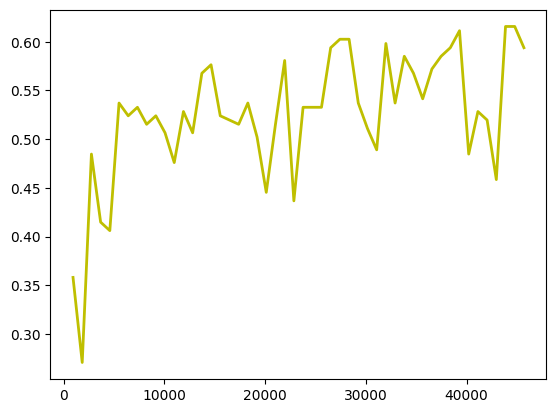

In [ ]:
NN = NeuralNetwork(samples=X_train, labels=y_train, eta=0.0001, epochs=50, size_hidden=64, optimizer="adagrad", verbose=True)
fitted = NN.fit()
if fitted is not None:
    no_epochs, accuracy = fitted
    plt.plot(no_epochs, accuracy, 'y-', linewidth=2, label='Adagrad; Eta=0.0001')
else:
    print("Training interrupted due to overflow.")

# Train with different learning rates
learning_rates = []
loss_reductions = []
for eta in np.logspace(-8, 1, 15):
    NN = NeuralNetwork(samples=X_train, labels=y_train, eta=eta, epochs=50, size_hidden=64, optimizer="adagrad", verbose=False)
    fitted = NN.fit()
    if fitted is not None:
        no_epochs, accuracy = fitted
        loss_reduction = accuracy[-1]
        learning_rates.append(eta)
        loss_reductions.append(loss_reduction)
    else:
        print(f"Training interrupted for eta={eta} due to overflow.")

if loss_reductions:
    plt.plot(learning_rates, loss_reductions, marker='o', linestyle='-')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss Reduction')
    plt.title('Loss Reduction vs Learning Rate')
    plt.xscale('log')
    plt.legend()
    plt.show()
else:
    print("No valid training results to plot.")


###Plot Activation Functions and Their Derivatives

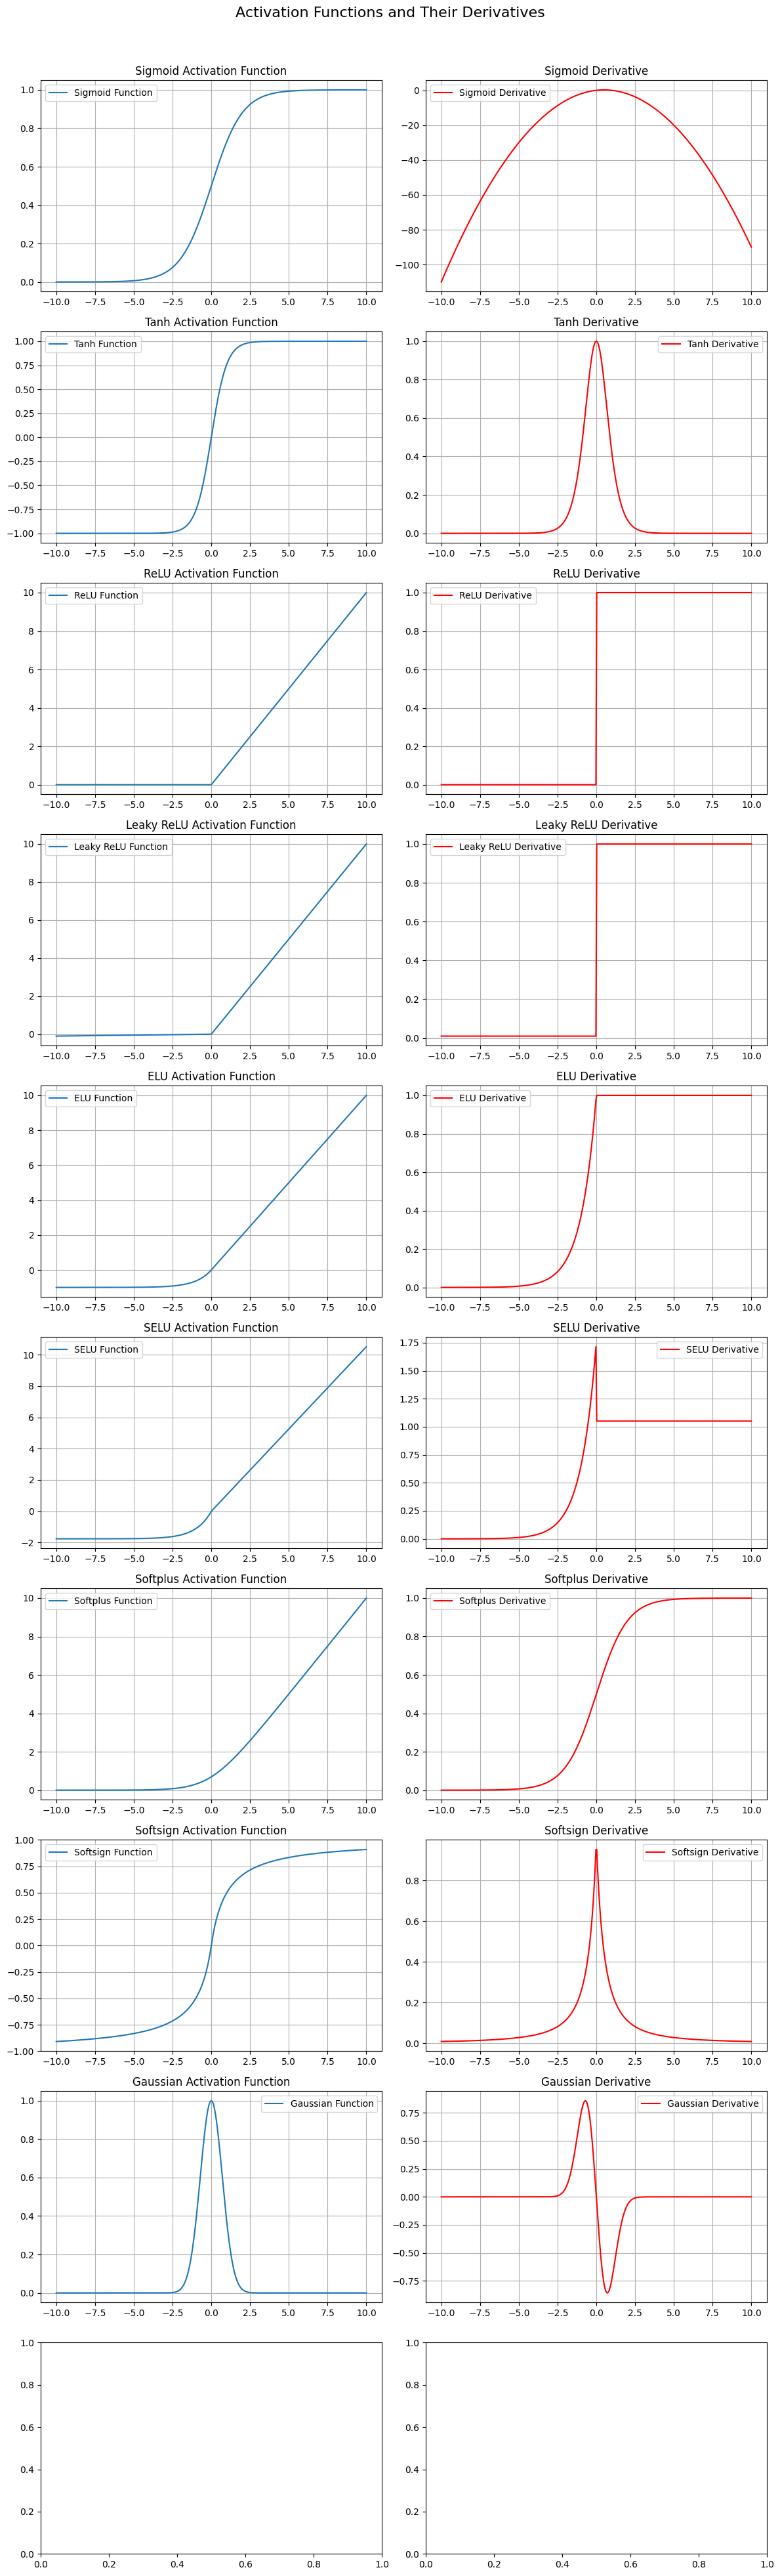

In [ ]:
activation_functions = {
    "Sigmoid": (lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x)),
    "Tanh": (np.tanh, lambda x: 1 - np.tanh(x)**2),
    "ReLU": (lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)),
    "Leaky ReLU": (lambda x: np.where(x > 0, x, 0.01 * x), lambda x: np.where(x > 0, 1, 0.01)),
    "ELU": (lambda x: np.where(x > 0, x, np.exp(x) - 1), lambda x: np.where(x > 0, 1, np.exp(x))),
    "SELU": (lambda x: 1.0507 * np.where(x > 0, x, 1.67326 * (np.exp(x) - 1)), lambda x: 1.0507 * np.where(x > 0, 1, 1.67326 * np.exp(x))),
    "Softplus": (lambda x: np.log(1 + np.exp(x)), lambda x: 1 / (1 + np.exp(-x))),
    "Softsign": (lambda x: x / (1 + np.abs(x)), lambda x: 1 / ((1 + np.abs(x))**2)),
    "Gaussian": (lambda x: np.exp(-x**2), lambda x: -2 * x * np.exp(-x**2))
}

x = np.linspace(-10, 10, 400)
fig, axes = plt.subplots(10, 2, figsize=(12, 40))
fig.suptitle('Activation Functions and Their Derivatives', fontsize=16)

for i, (name, (func, derivative)) in enumerate(activation_functions.items()):
    y = func(x)
    y_prime = derivative(x)
    axes[i, 0].plot(x, y, label=f'{name} Function')
    axes[i, 0].set_title(f'{name} Activation Function')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    axes[i, 1].plot(x, y_prime, label=f'{name} Derivative', color='red')
    axes[i, 1].set_title(f'{name} Derivative')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
